<a href="https://colab.research.google.com/github/costadomar/Portif-lio_projeto/blob/main/RGS_13_Case_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ajude **Santander** a identificar o valor das transações para cada cliente potencial. Esse é um primeiro passo que o **Santander** precisa acertar para personalizar seus serviços em grande escala.

Baixa o dataset *train* no url seguinte:  
https://www.kaggle.com/c/santander-value-prediction-challenge/data

Depois, pode deixar ele na pasta `colab_data` do `Drive` (com um *Drag and Drop*)

O case podera ser quebrado nas **6** partes seguintes:  
- **Identificar o problema**
  - Qual o tipo (classificaçao, regressao, clustering) de problema e porque? 
- **Necessidades de aplicar transformaçoes?**
  - Ex: *imputing* de valores null, *encoding* de colunas *string*, etc 
- **Separar os sets de treinamento e teste**
- **Baseline**
  - Achar uma baseline, um primeiro modelo para ter uma referencia
- **Escolher a metrica**
- **Melhorar o resultado**
  - Feature engineering, otimizaçao do modelo, hiperparametros, etc

#1. Identificando o problema

O problema apresentando pelo santander é de ***regressão***, devido a ter que identificar um valor de transação para um cliente em potencial, ajudando o Santander personalizar os seus servições de acordo com a necessidade de cada cliente.

#2. Carregando a Base de dados

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (14,6)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data_colab/train.csv")
df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,...,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,1300000.0,...,0,0,1100000.0,0,0,0,0.0,0.0,14800000,0.0,1200000.0,0.0,0.0,0,0,0,0,0.0,4000000,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,2000000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0


#3. Exploração dos Dados(EDA)

In [ ]:
print('*****Informações importantes sobre os dados******')
print('')
print(f'Variaveis: {df.shape[1]}')
print(f'Entrada: {df.shape[0]}')
print(f'Soma de dados ausentes: {df.isnull().sum().sum()}')
print('')
print('Tipo dos dados:')
display(df.dtypes)

*****Informações importantes sobre os dados******

Variaveis: 4993
Entrada: 4459
Soma de dados ausentes: 0

Tipo dos dados:


ID            object
target       float64
48df886f9    float64
0deb4b6a8      int64
34b15f335    float64
              ...   
71b203550      int64
137efaa80      int64
fb36b89d9      int64
7e293fbaf      int64
9fc776466      int64
Length: 4993, dtype: object

In [ ]:
df.describe(percentiles=[.1, .25,.5,.75,.9])

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,822e49b95,...,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4459.000000,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4459.0,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4459.0,4.459000e+03,4.459000e+03,4459.0,4.459000e+03,4.459000e+03,...,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4459.000000,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4459.000000,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03
mean,5.944923e+06,1.465493e+04,1.390895e+03,2.672245e+04,4.530164e+03,2.640996e+04,3.070811e+04,1.686522e+04,4.669208e+03,2.569407e+06,1.552158e+05,1.950500e+05,8.522090,3.595874e+03,2.258015e+06,2.680843e+05,4.588255e+04,4.451478e+04,3.968961e+05,2.883129e+04,1.940794e+03,4.483841e+05,7.989729e+04,1.548394e+05,1.128254e+05,1.148329e+05,3.377439e+03,0.0,3.794130e+05,1.202247e+05,7.426464e+05,4.994842e+03,1.725258e+06,1.941882e+05,0.0,9.338327e+04,6.296896e+05,0.0,1.249545e+06,1.200042e+06,...,2.412200e+03,3.767589e+05,6.669478e+05,4.281949e+04,6.279435,1.409112e+05,2.364780e+05,7.627485e+05,6.752640e+05,5.428654e+05,7.776979e+05,1.004851e+05,3.825025e+05,2.539583e+03,3.767661e+03,4.153891e+04,7.041224e+04,9.648562e+04,9.751240e+05,2.910967e+04,7.599802e+04,3.588248e+03,1.796016e+05,5.302810e+05,2.377396e+05,1.183135e+06,1.247793e+06,9.867683e+02,6.165015e+04,1.289495e+05,4.676057e+05,4.446239e+05,8.056219e+05,7.812966e+05,143.529939,1.213809e+05,3.573451e+04,3.123741e+05,9.219960e+04,2.279100e+05
std,8.234312e+06,3.893298e+05,6.428302e+04,5.699652e+05,2.359124e+05,1.514730e+06,5.770590e+05,7.512756e+05,1.879449e+05,9.610183e+06,1.587815e+06,2.397372e+06,569.068911,1.245435e+05,1.552298e+07,3.026910e+06,8.140674e+05,1.354504e+06,3.238243e+06,5.705388e+05,2.786022e+04,6.370644e+06,2.846440e+06,2.425794e+06,1.161275e+06,2.747535e+06,1.313839e+05,0.0,3.561409e+06,4.867503e+06,3.799941e+06,1.868664e+05,9.034308e+06,1.481349e+06,0.0,8.547764e+05,6.956380e+06,0.0,7.361173e+06,8.113234e+06,...,1.498586e+05,7.755051e+06,6.261373e+06,5.473370e+05,322.557139,2.052878e+06,1.533062e+06,5.816722e+06,7.444468e+06,4.250172e+06,4.287643e+06,9.150068e+05,2.799848e+06,1.508683e+05,2.515884e+05,1.179500e+06,2.810830e+06,1.114863e+06,9.750283e+06,7.912064e+05,1.206581e+06,2.396080e+05,1.660884e+06,4.497567e+06,4.109065e+06,1.139493e+07,6.878895e+06,6.589219e+04,2.124731e+06,1.335938e+06,4.068038e+06,4.428889e+06,4.513246e+06,6.839451e+06,9584.318507,4.720709e+06,1.614622e+06,4.318501e+06,1.635993e+06,1.811139e+06
min,3.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00000

As médias apresentadas, são valores na casa de milhões. Então, os clientes talvez estudados aqui nesse casa, são pessoas pj. Com isso, faz sentindo a média da variavel target ser de 5,9 mi. Tendo uma variancia alta de 8 mi aproxidamente.

Text(0.5, 0, 'Valor de Transação ($)')

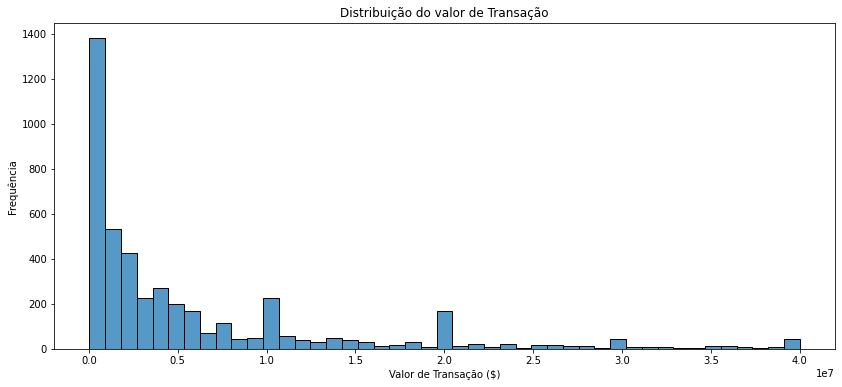

In [ ]:
sns.histplot(df['target'])
plt.title('Distribuição do valor de Transação')
plt.ylabel('Frequência')
plt.xlabel('Valor de Transação ($)')


Observação: O histograma mostra uma distribuição assimétrica a direita,mas aponta que a grande maioria fica com o valor proximo de 5 mi. Conforme verificado também no gráfico box-plot abaixo.

Text(0.5, 0, 'Valor de Transação')

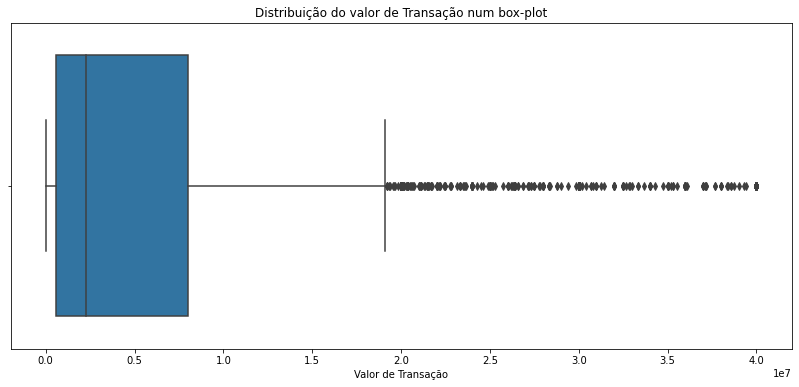

In [ ]:
sns.boxplot(data=df, x='target')
plt.title('Distribuição do valor de Transação num box-plot')
plt.xlabel('Valor de Transação')

Observação: O gráfico box-plot apresenta uma quantidade expressiva de outliers, na qual não serão removidos neste case, devido ter clientes que fazem transição de valores acima da média e por isso serão considerados num modelo que não sofre com influencia com outliers.

In [ ]:
df.duplicated().value_counts()

False    4459
dtype: int64

#4. Separação da base de Treino e Teste

In [ ]:
id = df["ID"]
y = df["target"]
X = df.drop(["ID", "target"], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

#5. Modelagem

Para fins de estudo, iremos utlizar 3 modelos: O linear Regression, O Randon Forest e o XGboost

##5.1 Baseline do Modelo

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
y_train_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)
print(f'MAE_treino: {mean_absolute_error(y_train, y_train_pred)}')
print(f'MAE_teste: {mean_absolute_error(y_test, y_pred)}')

MAE_treino: 13365.819988715726
MAE_teste: 406402827989822.06


Observação: Aqui foi usado o MAE como métrica, porque como é um valor a ser estimado, é bom para area de negocio saber a média de valor que se estar errando. O MAE dos dados do treino foi muito melhor que o de teste, mostrando um possivel overfit no dados, possivelmente por o dataset apresentra mais features que registros.

##5.2 Selecionando features para o modelo

Para contornar o overfit no modelo, se optou usar a função `SelectKBest`, que escolhe features da biblioteca `Sckit-learn` para um modelo atraves de testes estatísticos, selecionando os atributos que possuem uma forte relação com a nossa variavel target. Com isso, usamos o ` f_regression`, que é o metodo usado dentro da função para problemas de regressão.





In [ ]:
sel_kbest = SelectKBest(f_regression, k=45).fit(X_train, y_train)

In [ ]:
X_train_sel = sel_kbest.transform(X_train)
X_test_sel = sel_kbest.transform(X_test)

In [ ]:
X_train_sel.shape

(3567, 45)

###5.3 LinearRegression

In [ ]:
reg = LinearRegression().fit(X_train_sel, y_train)

y_train_pred = reg.predict(X_train_sel)
y_pred = reg.predict(X_test_sel)

print(f'MAE_treino: {mean_absolute_error(y_train, y_train_pred)}')
print(f'MAE_teste: {mean_absolute_error(y_test, y_pred)}')

MAE_treino: 5322548.588998503
MAE_teste: 5230263.099091363


Fazendo uma comparação com  a métrica MAE antes da seleção de features, vimos que a predição do modelo melhorou significativamente. Mas, a métrica utilizada aqui não é uma das melhores para o case. Mas, o valor dado no MAE, ficou na média que vimos na variavel target.

####5.3.1 Mudando a métrica

Vamos usar o `mean squared log error`, devido ser a métrica escolhida pelo Santander no case disponivel no Kaggle.

In [ ]:
y_train_pred = reg.predict(X_train_sel)
y_pred = reg.predict(X_test_sel)

Filtrando os valores maiores que zero, pois a métrica escolhida não consegue ler valores negativos que aparecem devido a regressão linear.

In [ ]:
y_train = y_train[y_train_pred > 0]
y_train_pred = y_train_pred[y_train_pred > 0]
y_test = y_test[y_pred > 0]
y_pred = y_pred[y_pred > 0]

In [ ]:
print(f'MSLE_treino: {mean_squared_log_error(y_train, y_train_pred)}')
print(f'MSLE_teste: {mean_squared_log_error(y_test, y_pred)}')

MSLE_treino: 3.9112778699926625
MSLE_teste: 3.74522707164624


Com o MSLE podemos verificar melhor o desempenho do modelo nesse caso. A métrica não penaliza erros grandes, e só prever pequenas diferenças entreo valor previsto e o real.

##5.4 RandonForestRegressor




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [ ]:
sel_kbest = SelectKBest(f_regression, k=45).fit(X_train, y_train)
X_train_sel = sel_kbest.transform(X_train)
X_test_sel = sel_kbest.transform(X_test)

In [ ]:
regr = RandomForestRegressor(max_depth=6, random_state=0)
regr.fit(X_train_sel, y_train)

RandomForestRegressor(max_depth=6, random_state=0)

In [ ]:
y_train_pred = regr.predict(X_train_sel)
y_pred = regr.predict(X_test_sel)


print(f'MSLE_treino: {mean_squared_log_error(y_train, y_train_pred)}')
print(f'MSLE_teste: {mean_squared_log_error(y_test, y_pred)}')


MSLE_treino: 3.8324753278229275
MSLE_teste: 3.719739927585444


O valor da métrica no Randon Forest foi relativamente melhor do que no Linear Regression de ~ 0.03.

###5.4.1 Otimizando os Hiperparametros

Vamos utilizar o algoritmo Grid Search que é encontrado na biblioteca do sklearn. Ele vai buscar a melhor configuração de um conjuto de valores pré-estabelecido.

In [ ]:
parameters = {'max_depth':[2, 6, 10, 20], 'n_estimators':[20, 50, 100, 200]}
regr = RandomForestRegressor(random_state=0, n_jobs=-1)

clf = GridSearchCV(regr, parameters)
clf.fit(X_train_sel, y_train)

GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [2, 6, 10, 20],
                         'n_estimators': [20, 50, 100, 200]})

In [ ]:
y_train_pred = clf.predict(X_train_sel)
y_pred = clf.predict(X_test_sel)


print(f'MSLE_treino: {mean_squared_log_error(y_train, y_train_pred)}')
print(f'MSLE_teste: {mean_squared_log_error(y_test, y_pred)}')

MSLE_treino: 2.6419218238697284
MSLE_teste: 3.2293333350212725


Como podemos verificar o modelo melhorou em ~ 0.49. Bastante significativa só com um simples ajuste de hiperparametro.

In [ ]:
clf.best_estimator_

RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs=-1, random_state=0)

##5.5 XGBoost Regressor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [ ]:
sel_kbest = SelectKBest(f_regression, k=45).fit(X_train, y_train)
X_train_sel = sel_kbest.transform(X_train)
X_test_sel = sel_kbest.transform(X_test)

In [ ]:
parameters = {'max_depth':[2, 6, 10, 20], 'n_estimators':[200]}

In [ ]:
xgbGrid = GridSearchCV(XGBRegressor(),parameters, verbose=True)

In [ ]:
xgbGridModel = xgbGrid.fit(X_train_sel, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[18:13:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:51] WARNING: /workspace/src/objective/regres

In [ ]:
xgbGridModel.best_params_

{'max_depth': 2, 'n_estimators': 200}

In [ ]:
y_train_pred = xgbGridModel.predict(X_train_sel)
yGrid_pred = xgbGridModel.predict(X_test_sel)


In [ ]:
y_train = y_train[y_train_pred > 0]
y_train_pred = y_train_pred[y_train_pred > 0]
y_test = y_test[yGrid_pred > 0]
y_pred = yGrid_pred[yGrid_pred > 0]

In [ ]:
print(f'MSLE_treino: {mean_squared_log_error(y_train, y_train_pred)}')
print(f'MSLE_teste: {mean_squared_log_error(y_test, y_pred)}')

MSLE_treino: 3.3821099193234208
MSLE_teste: 3.4530056731640535


Já, o XGboost não foi tão performático que o Randon Forest,talvez um ajuste melhor de hiperparametro, conseguiriamos melhorar a métrica.

#6. Conclusão

O modelo que apresentou uma melhor perfomance dos dados foi o Randon Forest regresson, apresentou um `mean_squared_log_error` de 3.22 com ajuste dos hiperparametros, já o linear Regression apresentou a pior métrica de 3.74. Os dados ainda podem melhorar, fazendo um melhor ajuste nos hiperparametros no modelo e talvez utilizando outros modelos para teste.